# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [20]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

# n_traits = 10
# active_traits = 10


In [21]:
generate_student_name()

'PHUTHY CORE '

In [22]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [23]:
active_traits = 100
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.075196407410573
th 7.130072753253939 10.205269160664512
null-task passrate 0.7310585786300049
all-null passrate 2.4843785557240134e-14
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
limits 0.9978283039153395 0.9978283039153395
[[1 2 3]
 [7 8 9]]
(2, 3)


In [24]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [25]:
class Question():
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix

#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
#         n_c =  numpy.random.choice(range(1,active_traits))
        n_c = nt
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= uniform(min_diff, max_diff) #(1,11)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.thetas[c] = random.uniform(min_a, max_a)  
            self.thetas[c] = uniform(min_a, max_a) #(7,22)


In [26]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [27]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [28]:
# def create_encounter_keys(volume, n_active):
#     prs = [ uniform(0.01,0.99) for _ in range(volume) ]
# #     print(caius)
#     compons = [ randint(1,n_active) for _ in range(volume) ]
# #     print(compons)
#     comp_ps = [ p**(1/n) for p,n in zip(prs,compons)]
# #     comp_ps = [ p for p,n in zip(prs,compons)]
# #     print(comp_ps)
#     spreads = [ -math.log((1.0/pr)-1.0) for pr in comp_ps ]
    
#     hard_comp_del = min(spreads)
#     easy_comp_del = max(spreads)
#     offset = (easy_comp_del - hard_comp_del)/2
#     baseline = 1
#     beta_min = baseline+0
#     # beta_max = baseline+round(offset,1)
#     # theta_min = baseline+round(easy_comp_del - offset,1)
#     # theta_max = baseline+round(easy_comp_del,1)
#     beta_max = baseline+(offset)
#     theta_min = baseline+(easy_comp_del - offset)
#     theta_max = baseline+(easy_comp_del)

#     print(beta_min, beta_max)
#     print(theta_min, theta_max)

#     ths=[]
#     bs=[]
#     lowest = math.inf
#     for s in spreads:
#         choyce = random.choice(["th","b"])
#         if choyce=="th":
#             th = random.uniform(theta_min, theta_max)
#             b = th-s
#             lowest = b if b < lowest else lowest
#         else:
#             b = random.uniform(beta_min, beta_max)
#             th = b-s
#             lowest = th if th < lowest else lowest
#         ths.append(th)
#         bs.append(b)
    
#     ths = [th-lowest for th in ths]
#     bs = [b-lowest for b in bs]
        
#     plt.hist(ths)
#     plt.show()
#     plt.hist(bs)
#     plt.show()
# #     print(spreads)
#     plt.hist(spreads, bins=25)
#     plt.show()
#     return prs

# create_encounter_keys(1000,5)


In [29]:
# def create_qs_from_blobs(n_qs, n_clusters, nt=n_traits):
#     from sklearn.datasets.samples_generator import make_blobs
#     from sklearn.preprocessing import MinMaxScaler
    
#     #beta_min,beta_max
#     sc = MinMaxScaler(feature_range=(beta_min, beta_max))
    
#     X, y = make_blobs(n_samples=n_qs, centers=n_clusters, n_features=nt, cluster_std=2, random_state=666)
# #     baseline = numpy.min(X)
# #     X = X - baseline
#     X = sc.fit_transform(X)

#     df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
#     colors = {0:'red', 1:'blue', 2:'green', 3:'yellow', 4:'black'}
#     fig, ax = plt.subplots()
#     grouped = df.groupby('label')
#     for key, group in grouped:
#         group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
#     plt.show()
    
#     qns = []
#     for qix, (blob, y) in enumerate(zip(X,y)):
#         qn = Question(qix, 0,0, nt=nt, nnw=nnw)
#         qn.betas = blob
#         qn.group = y
#         qns.append(qn)
        
#     mags = []
#     no_comps = []
#     for q in qns:
#         comps = [c for c in q.betas if c>0]
#         mag = sqrt(sum([ pow(b, 2) for b in comps ]))
#         print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
#         mags.append(mag)
#         no_comps.append(len(comps))
        
#     plt.hist(mags)
#     plt.show()
#     plt.hist(no_comps)
#     plt.show()
    
#     qn_table = BigTable((n_qs, nt),min_w=0, max_w=beta_max)    
#     return qns, qn_table

In [30]:
def create_qs(n_qs, beta_min, beta_max, nt, nnw):
    random.seed(666)
    numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

In [31]:
def create_students(n_students, theta_min, theta_max, nt, nnw):
    random.seed(666)
    numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list, psi_table
    

In [32]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
#     qn_qmx.trainable = True
#     psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)
#     psi_qmx_row = psi_qmx(psi_sel)

#     not_q = Lambda(lambda z: 1.0 / (1.0 + K.exp(10.0*z-5)), name="NOT_GATE")(qn_qmx_row)
#     scale = Lambda(lambda x1: 10.0*x1)
#     scale_sub = Lambda(lambda x2: 10.0*x2 - 5.0)

    
    ####
    # q0,s0 -> 1
    # q0,s1 -> 1
    # q1,s0 -> 0
    # q1,s1 -> cPr
    
#     p = scale_sub(psi_row)
#     not_q = scale(not_q)
#     qmx_selector = add([p, not_q])

    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)
#     q_masque = qn_row
#     s_masque = psi_row

    q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
    q0 = Lambda(lambda q: 1-q)(q_masque)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)

#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])
    
#     topped_up = Lambda(lambda ps_q:  K.clip(ps_q[0]+(1.0-ps_q[1]), 0,1))([Prs_holed, q_masque])

#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [33]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                pp,passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [34]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [39]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 10
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    vqices = array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
    vpsices = array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
    vpfs = array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    qz = qices
    sz = psices
    pfz = pfs

    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))

            psi_wgts = s_table.get_weights()[0]
#             psi_qmx_wgts = s_qmx_table.get_weights()[0]
            th_rmses = []
            for s in psi_list:
#                 masque = psi_qmx_wgts[s.id]
                spred = psi_wgts[s.id] #* masque
                sreal = s.thetas
                err = numpy.abs(numpy.sort(spred) - numpy.sort(sreal))
#                 err = cosine(s_thetas, s_wgts)
                th_rmses.append(err)

            qn_wgts = q_table.get_weights()[0]
#             qn_qmx_wgts = q_qmx_table.get_weights()[0]
            b_rmses = []
            for q in master_qs:
#                 masque = qn_qmx_wgts[q.id]
#                 print("masque =", masque)
                qpred = numpy.sort(qn_wgts[q.id])
#                 print("qpred =", qpred)
                qreal = numpy.sort(q.betas)
#                 print("qreal =", qreal)
                err = numpy.abs(qpred - qreal)
#                 err = cosine(q_betas, q_wgts)
                b_rmses.append(err)
            
            print("i =",i)
            th_rmse = numpy.mean(th_rmses)
            th_fit_rmses.append(th_rmse)
            print("th RMSE=", th_rmse)
            b_rmse = numpy.mean(b_rmses)
            b_fit_rmses.append(b_rmse)
            print("b RMSE=", b_rmse)
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            av_rmse = loss
            print("av RMSE=",av_rmse)
            if av_rmse <= min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
                qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h, th_fit_rmses, b_fit_rmses


In [36]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

Q:0, difficulty=140.74 across 100 components
Q:1, difficulty=137.84 across 100 components
Q:2, difficulty=132.91 across 100 components
Q:3, difficulty=136.76 across 100 components
Q:4, difficulty=126.72 across 100 components
Q:5, difficulty=133.89 across 100 components
Q:6, difficulty=147.30 across 100 components
Q:7, difficulty=139.80 across 100 components
Q:8, difficulty=126.86 across 100 components
Q:9, difficulty=143.78 across 100 components
Q:10, difficulty=134.47 across 100 components
Q:11, difficulty=137.28 across 100 components
Q:12, difficulty=138.17 across 100 components
Q:13, difficulty=127.61 across 100 components
Q:14, difficulty=139.09 across 100 components
Q:15, difficulty=146.63 across 100 components
Q:16, difficulty=127.60 across 100 components
Q:17, difficulty=140.03 across 100 components
Q:18, difficulty=139.39 across 100 components
Q:19, difficulty=137.83 across 100 components
Q:20, difficulty=140.59 across 100 components
Q:21, difficulty=144.96 across 100 component

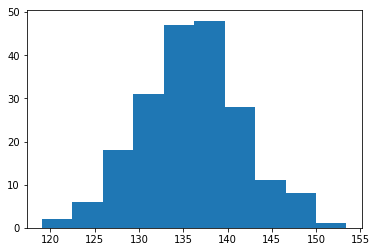

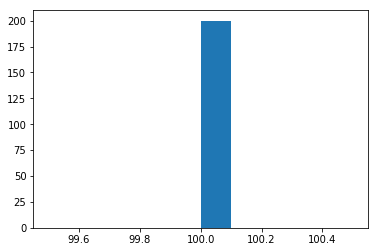

qid 0 [10.9407500364082, 22.753992210988127, 3.0290681433672004, 22.122579509878584, 10.241444171347066, 8.619960583489938, 13.180822336187381, 19.411419456533437, 3.8651242410448603, 1.757163981224957, 14.840419115698044, 20.426416959846634, 14.431278094415623, 18.35397115907176, 10.26366724005457, 21.214959481599877, 3.2713691196853323, 16.66784490144905, 21.276497289549646, 2.8074963797347907, 12.327652548895829, 7.845360016073855, 12.701726359074064, 2.0091921551064456, 12.986203362563774, 4.734959766030762, 3.6906163573113195, 11.340998522877818, 8.989418645189557, 14.645281709534821, 11.255192918649602, 16.455311330186635, 20.620165130008093, 10.194038130038786, 10.224510345833721, 10.55626093027735, 6.545562652504962, 12.013787197417814, 10.028897430661422, 11.889215067606024, 1.3688334265942077, 20.826964113661695, 12.985477169255779, 18.849908650294743, 10.376616806171812, 1.5087881150116451, 21.056165483933043, 13.97004263787164, 9.353338139463231, 18.479445856868114, 11.1413

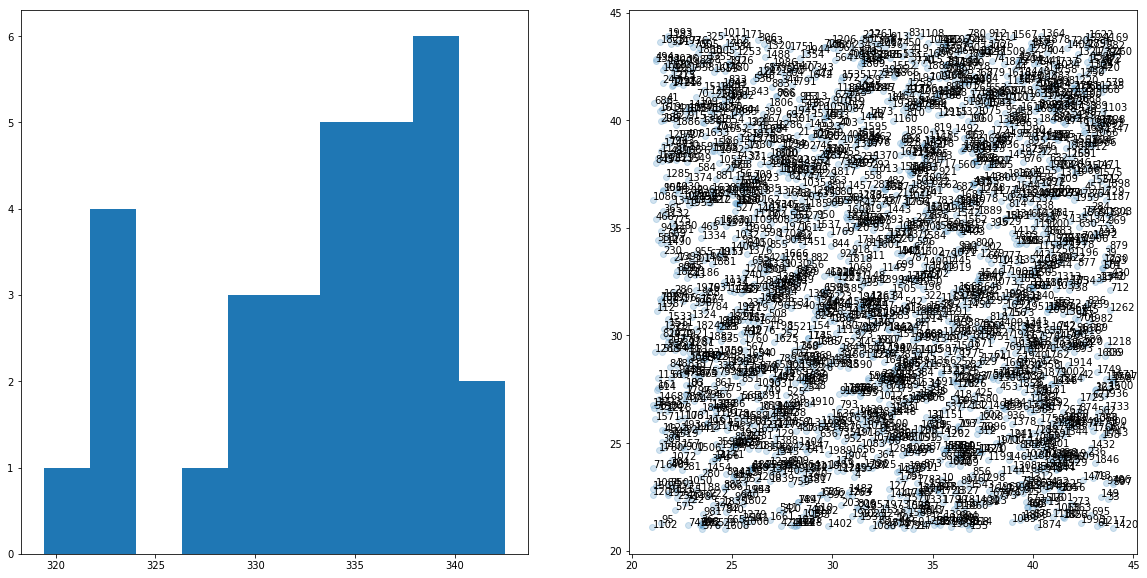

----0

>>Passed 200704/400000
----0

>>Passed 200500/400000
<__main__.BigTable object at 0x7f2114edddd8> <__main__.BigTable object at 0x7f211421fe80> Tensor("psi_select_4:0", shape=(?, 1), dtype=int32) Tensor("q_select_4:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (200, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (200, 100)
'rows' shape, (?, 100)
kk (2000, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (2000, 100)
'rows' shape, (?, 100)
dif (?, 100)
Pr (?, 1)
[ 36.84820938  29.15011215  30.84503555  38.35461044  23.45425224
  23.3055172   31.8414135   21.08634949  33.11000824  37.7673111
  22.39219093  33.19727325  33.72828293  26.09714699  30.86427307
  39.29456711  38.88507462  36.84125137  39.9205246   30.03222275
  33.22498703  26.60163689  35.60459137  32.16890335  36.42733383
  27.85201836  38.37541199  30.66963577  41.34389114  37.93497086
  36.81014633  33.70760727  30.66947174  33.79465485  28.8790741
  35.74673462  39.60245895  33.46877

[ 36.82147598  38.67274475  35.71688843  37.68455505  42.37118912
  37.18809509  24.31634521  32.97664642  27.64737701  39.58744049
  24.28996468  32.21452332  22.65993309  33.81115341  27.42668152
  40.88196182  38.65942001  38.73388672  34.76139069  28.28263664
  36.65947342  23.94028091  30.24158669  30.60914993  24.49886703
  22.16665459  32.92564392  40.64341736  23.33792305  34.87481308
  38.78303146  27.68353081  32.78197098  25.7534008   40.81837082
  41.30567169  34.60631561  40.47898102  35.53343964  40.96739197
  28.98583603  36.02086258  24.60325432  39.95451355  33.21618271
  26.51977158  25.50528908  27.27098083  34.90117645  29.73571396
  39.5439682   28.27532959  26.0766201   32.08174896  23.65761757
  37.164505    24.01335907  31.00590324  35.33481598  37.62904358
  41.22744751  38.01809311  25.85456657  33.46780014  25.29974365
  28.8052845   41.84009552  33.39497757  39.24982834  38.67337036
  22.17400742  28.97157478  40.42129898  39.7903595   26.59794044
  38.59682

[ 43.12854004  39.26865005  26.97488785  32.67790222  38.50287628
  36.71087265  37.89413834  37.94028091  38.22806549  33.48746109
  37.23955154  37.18390656  40.26704407  37.23200607  31.06636047
  21.53554153  36.04413223  42.28865814  37.85006714  22.8386116
  40.12868118  26.53695297  27.39776802  24.05515862  28.19392395
  36.74388504  40.0766449   39.04943466  37.66297531  23.52715111
  22.137146    31.85147476  42.28514862  42.45572662  36.62376404
  38.92618942  33.87173462  26.06687164  25.58418846  35.23947144
  29.1508503   32.87964249  28.69882584  36.9370575   39.68779373
  41.31777954  24.34567261  27.03051758  21.13049316  27.81461143
  43.08446503  34.7737999   38.92498398  33.24370575  28.68941116
  35.36006165  27.12539101  29.30185318  30.86090088  23.34591103
  37.4102478   40.10346985  24.13682556  37.42317963  29.10221291
  41.62398148  42.45162201  32.27751541  32.60850525  32.74539185
  39.95592499  22.96227074  31.9667244   38.17987061  24.31407547
  39.207458

[ 27.08206749  42.0199585   42.22742462  21.4741497   40.16688919
  30.93027496  23.50057983  41.05228424  37.08095932  35.95179749
  37.84953308  25.01939583  36.73895264  34.97975922  28.87427902
  42.6275177   30.34126472  23.97256279  24.00690651  27.35585785
  34.34721756  22.36004066  24.8820591   30.48049545  39.30842972
  37.0629921   36.91392899  36.51734543  37.90301514  43.93928528
  34.7279129   38.53443146  39.57834244  25.34122276  28.93682861
  25.89952278  38.11768341  28.98762131  41.64203644  28.58107567
  37.33055878  25.3092823   23.07044411  33.38916397  26.88579178
  21.00279427  27.0459404   33.89431     21.10088539  32.22177124
  41.55450058  21.62516594  25.95064926  26.33140564  26.06786728
  26.81085205  37.20633698  27.99852562  40.1068306   43.78199005
  40.96156693  26.99800682  29.70956421  23.37737465  43.25944138
  37.87442398  39.19527054  28.6406765   21.4969635   27.90024185
  36.62065887  38.37238693  42.03889847  42.1872139   32.28496933
  28.68167

[ 33.33029938  21.24001503  21.49163437  32.1628685   35.88763809
  39.52294159  26.12471962  26.91009521  39.50925827  40.03792572
  35.78350067  29.28981209  40.92162323  34.11621094  30.14522934
  40.8295784   26.08522224  40.58272934  42.05075836  33.32833862
  28.07284927  26.53223801  23.76199913  28.52692986  27.36101341
  22.86560059  42.79352188  27.39492607  37.72937775  28.77546501
  24.8996048   24.56484032  42.95295715  22.3090229   37.89980316
  30.25297737  41.8341217   39.67959976  28.83558273  35.66520309
  29.45707512  25.9749794   23.46635246  25.36533546  28.89328194
  35.51965332  29.97973633  34.01893616  32.95645905  31.96307755
  42.27983475  37.84788895  35.01596832  32.49510956  40.88818359
  41.65523911  41.40700912  35.23675537  33.40076447  39.02096939
  28.73970413  40.18030167  42.51625061  37.23859406  34.36932755
  42.16029358  43.0779686   27.01014328  42.01367188  27.99288559
  40.97656631  29.56575584  33.87438202  39.63251495  34.51654816
  39.80123

  23.18028069  31.93800926  34.65612411  29.45934105]
[ 37.49833679  23.5375843   38.09455872  23.7049942   43.2583847
  27.58116341  36.00758362  34.14740372  35.35383224  38.40382385
  43.82251358  33.45470047  37.03861618  43.20399475  29.44836617
  42.75606155  23.00527191  27.82567406  35.86407089  23.10894966
  42.83853531  41.36932755  28.44245911  31.66157722  32.91760254
  21.78229332  42.85134125  24.48564529  35.66917801  27.87818146
  34.8694191   26.44637489  29.52224159  36.7052803   24.64388657
  28.95414925  42.65048218  31.92192078  42.68785477  39.07553864
  40.29814148  21.22053337  43.75613785  41.72422791  41.31207275
  42.51470184  39.5141449   21.73402405  23.54068756  35.63534546
  27.92918587  23.44330788  33.95442581  42.14265823  43.7336998
  27.39308548  25.0737896   25.22610855  21.9929924   27.10733604
  34.67653656  36.72212219  22.92118454  38.9389267   30.35417557
  28.54936981  41.70634842  32.29894638  24.05073166  40.79433441
  29.4132061   43.456771

[ 29.52172852  38.39979553  28.32989883  35.17763138  26.83897209
  29.71696854  23.37427521  24.22451019  33.16077805  33.50212479
  28.98335457  27.96447182  32.57863617  24.01534843  21.46607971
  26.30225563  41.24855042  39.17431641  27.44906425  43.60676575
  36.44178772  43.05678177  40.22240448  24.06389046  25.95115471
  36.37824631  36.68134689  34.73570251  25.80087471  25.02305794
  38.1439743   22.95851135  27.61472702  31.5015583   36.38291168
  39.55893326  39.05464554  23.20884895  42.04766846  38.45520782
  21.53279495  29.68537521  36.36779022  32.55253983  28.58704376
  27.0021286   26.92548752  29.69988632  36.86087036  36.847229
  35.83751678  22.50889587  27.15044022  33.60755157  34.43373871
  26.99272346  24.44165611  29.21303558  22.29872704  41.85919571
  32.23487854  25.32946587  26.64802742  39.01555252  36.88972855
  39.29849625  29.01541519  43.82761383  34.6480751   37.23233414
  21.00753593  36.00056076  29.31744003  25.86692429  26.73980522
  43.1314544

[ 25.52311707  40.61851883  32.4610672   37.94248581  36.18859482
  42.58744431  29.05316734  27.15966606  42.94218445  27.56983376
  27.0110302   28.07257843  35.68915558  27.24398994  42.66416931
  26.26265526  37.50077438  24.50118256  32.8576355   25.01740646
  40.79674911  21.32458115  24.03667259  21.6439476   27.9636364
  26.11969185  36.66198349  40.32925034  38.58625793  33.18979645
  22.65856361  31.11232567  36.63938904  40.02883911  28.43818283
  42.53094482  39.85990906  23.28306389  43.53656006  36.75156403
  30.35839462  27.5562706   23.69422531  21.2146759   28.38759232
  38.93784332  30.26613998  41.77144241  34.96357727  30.27033424
  28.99942207  28.42060661  26.98954964  25.16696167  43.46276474
  33.15939331  42.98033905  21.94674683  35.81610107  25.56562042
  35.67053223  21.42147446  30.41600037  35.73914719  35.33972931
  42.38104248  27.762146    22.38687134  41.07881165  34.62082291
  23.72156906  24.85293388  39.81371307  35.46488571  38.25563812
  29.330785

  36.71094894  31.17087364  34.00924301  33.28805161  36.364254  ]
[ 28.26637459  30.32794189  31.70715141  34.67077637  21.68445015
  31.42103958  29.2994442   30.84586143  24.34771919  25.23818398
  42.71104813  30.2942009   26.93046188  27.14551926  26.12465286
  36.18610001  42.03237534  28.76757812  25.7221489   23.96191978
  23.23646736  26.50889206  43.54393387  30.75064659  33.31835938
  25.31600571  38.56804276  23.86081123  43.01525497  28.16950035
  31.40434837  29.3507309   34.23815155  35.69735718  25.03293228
  26.43233299  40.24007416  42.00944901  37.04520416  23.79184341
  25.64842606  23.48273468  21.51054764  23.1888485   41.04092407
  29.47263145  39.94255066  24.96587753  38.61997604  29.71102524
  30.89344978  36.3932724   27.16351318  32.29430771  31.35034752
  29.00488281  36.15574265  42.524086    38.84151077  30.22606277
  39.69753265  30.08171272  24.26327515  34.28759384  41.9749794
  43.94807434  40.58385086  25.67588043  23.61061096  33.31082916
  31.85617

  32.65160751  42.58946991  27.31840515  35.65146255  36.84747696]
[ 34.71153641  32.62234116  29.8884449   40.83552933  26.94233131
  26.63798904  29.4487915   40.32814407  41.77468491  32.49399185
  42.38985825  40.53029633  29.76194572  21.72335815  29.50028992
  34.46539307  43.89236069  35.1578331   28.03078651  26.35119438
  22.08283615  26.71158981  43.82386398  29.35402679  26.22513771
  38.76692581  25.34390259  39.42357635  32.16975403  31.25644493
  34.4772644   36.61471176  35.13672638  29.83473206  43.94039154
  40.54452896  40.42008591  39.14521408  35.25030899  24.73310852
  22.11420822  28.77574348  32.54035568  42.55836105  39.86930084
  31.29555511  43.75409317  23.20918465  41.19279099  36.11363602
  24.42087173  35.17861557  23.10923386  32.47606659  25.20488167
  41.57893753  29.93804359  41.32337189  25.03035927  27.17746544
  41.83977127  24.49403572  30.39181519  41.27446365  23.18329811
  29.12062073  36.55940628  26.55963135  22.10091591  35.06287384
  42.0570

  38.85184479  43.01448059  42.84076309  34.39675903  41.25590134]
[ 22.54864883  42.76549911  24.13057709  33.09889221  39.89915466
  43.73996353  27.09442139  23.98676872  23.84266663  24.76782799
  29.45712662  36.84326935  40.95966339  38.7642746   35.17571259
  24.69057846  35.72140503  30.55581665  26.10451317  41.74369431
  29.83267021  25.63078308  28.83921051  42.16273499  39.05077362
  28.45968819  22.65504456  31.97836876  34.09293747  31.92029762
  33.51204681  38.43241882  39.09695435  40.61891556  22.68864059
  25.0688343   27.1135807   23.40945435  40.7733078   35.85335922
  28.56373596  31.00615883  32.75900269  32.27844238  35.55907059
  30.84528732  22.15367889  22.7842865   33.75128937  23.34495735
  39.67453766  43.37927628  29.55737686  33.81917572  31.4814682
  24.42761993  33.60396194  43.35433578  28.4876442   29.08583069
  43.60993576  33.00351715  26.93602943  35.02447891  36.90555954
  42.52740097  31.41827202  43.94429779  43.86904144  31.74068451
  22.33576

  26.15989113  33.72282791  26.58551788  38.11818314  39.55457687]
[ 22.12619019  40.50307083  33.53871536  27.38609505  33.24917221
  31.33839417  29.4765358   32.03804779  23.46005821  31.88904953
  23.5582962   40.33515167  25.48597336  35.28526688  23.22996902
  21.73752213  41.88532257  41.97148895  28.46483994  32.30166626
  22.64211845  30.37470055  31.54413223  27.15966415  42.19464111
  40.94494247  33.87719345  43.47063446  43.7959938   30.98395729
  43.33075714  43.07873154  35.43210983  30.72742271  36.92164993
  32.64116287  35.5245018   40.18556213  26.6570816   22.45515442
  37.03248215  25.41465569  39.82872009  31.92803192  34.95640564
  28.88387299  25.7966404   25.77456665  29.48240089  23.79766083
  33.93528748  42.32607269  23.60415459  40.63040924  29.00571632
  25.74020004  42.37483215  33.35066986  27.39195824  31.08205795
  22.87716866  33.01383209  42.67763138  22.37539482  31.70899963
  38.69975281  23.29045486  43.76138306  22.41902161  23.72250175
  40.2831

  31.97654533  31.98509979  28.41364479  27.97899628  43.26147079]
[ 43.51639175  30.68855858  25.88297462  22.93964958  21.05906868
  38.45697021  41.06607437  30.33060074  28.58349991  23.95788765
  33.9389534   25.6193676   41.60395432  34.22677612  27.84757996
  36.06435013  35.26807022  30.43893242  42.05115891  22.77373123
  38.98443985  31.27515793  41.52653885  31.86911201  38.32928467
  31.43697357  29.00419235  36.63553619  21.09058189  27.9742012
  43.13802338  33.41648102  25.57681465  40.7804184   35.39127731
  21.99571228  25.20014954  31.20470238  30.2430191   22.61399078
  36.62361145  43.30072784  22.6119709   27.59459305  24.18758392
  38.08956528  31.04048157  23.57000351  23.26236343  40.07949066
  32.67071152  24.69859886  40.11046982  21.03487968  24.42543602
  31.64317322  26.00921059  26.72699165  28.78329277  43.84753036
  22.96709442  33.50799561  30.94252014  30.62746811  33.43336487
  33.97199631  38.49784851  37.78152466  29.03550339  41.03513718
  35.42052

[ 25.60854721  43.35412598  37.99908066  22.94434357  23.44340706
  41.22926331  39.03617096  40.78077316  22.22538376  24.65911484
  30.91503716  22.96640968  25.09078217  25.20635605  26.95728302
  28.17076683  38.87387085  43.13654327  23.29581451  26.09036827
  31.89616394  27.63410759  40.37732315  31.81601715  31.15442657
  29.48607445  35.92008972  41.37338638  27.94721031  40.48991394
  27.69954491  33.43756104  32.28109741  22.14753342  42.99343491
  32.40235901  22.46350098  26.02511787  27.47192001  30.08159447
  31.69672203  28.85528946  28.20026016  40.60096359  30.58060646
  26.54253006  36.42025375  39.52627563  35.69848633  28.73199081
  24.91786766  32.91887665  42.88030243  39.76919174  33.61424255
  43.99969864  28.99223137  35.56970596  24.46663284  35.38921356
  41.49596405  40.64366531  34.97690964  41.28279114  30.10813332
  40.58097458  42.33308411  41.11405563  39.1961937   22.88390923
  36.07777405  25.10110283  33.03507614  22.36401176  40.80774307
  31.46908

  20.30951118   1.21411097  20.54549217  20.34353065   9.5839119 ]
[ 16.08171272  19.70420837   6.53560781   4.77002239   8.93049526
  19.28534508  13.30482388  12.52167702  17.47966957  12.90197945
   9.57097912  12.31420422   5.86693954   7.52041292  16.71525764
  17.15950394  10.05075359  22.09608269  12.86454296   9.43129826
   7.80421066  10.35965633  18.06218147  10.08285713  15.78656864
  19.44056892  18.32024193   1.75687087  21.88669014   4.23058176
  15.93376827  17.09706306  17.19437408   8.19488716   2.26818252
  13.03850937   5.21484852   9.56747246   1.33766139  16.36235428
   2.64408422  20.10129547   1.07776964  17.53160286  22.74642754
  13.37647438  19.73724556   5.61752558  21.71598625  18.15362167
   1.17538726  18.19085884   4.2363739    7.00536203  12.60944557
   1.11338139  19.07163811   2.29672599  17.83794022  17.07321167
   4.12515402   9.4421196    7.49358368   4.5299859   17.71051407
   4.35021067  14.68713474  11.62857246   7.87679291   6.18535376
  11.4098

[ 42 116 128 ...,   2 134 127]
[   0    0    0 ..., 1999 1999 1999]
[0 0 0 ..., 1 1 0]
i = 0
th RMSE= 1.00618450106
b RMSE= 0.929840134675
0.915721045661 0.319469417998 0.504905
av RMSE= 0.915721045661
patience reset to 10
i = 10
th RMSE= 0.977329387482
b RMSE= 0.997136223338
0.747952706227 0.266562899492 0.558315
av RMSE= 0.747952706227
patience reset to 10
i = 20
th RMSE= 0.995739482086
b RMSE= 1.1520091492
0.707814338098 0.252140023209 0.57898
av RMSE= 0.707814338098
patience reset to 10
i = 30
th RMSE= 1.00118296628
b RMSE= 1.24693584037
0.694191027892 0.247167066979 0.58571
av RMSE= 0.694191027892
patience reset to 10
i = 40
th RMSE= 0.994041175529
b RMSE= 1.28043884679
0.689239431179 0.245063116229 0.5907975
av RMSE= 0.689239431179
patience reset to 10
i = 50
th RMSE= 0.980581896971
b RMSE= 1.26361005863
0.689366422732 0.244739727142 0.5932475
av RMSE= 0.689366422732
patience now 9
i = 60
th RMSE= 0.967452794791
b RMSE= 1.22309510607
0.691101588571 0.244990282922 0.5950075
av RMS

1260

In [40]:
from IPython.display import clear_output
serieses = []
min_errs = []
n_qs = 200
n_students = 2000
opt = Adam(lr=.1)# (lr=.75)

# 1 (1836, (4279, 4082, 825, 814), 3, 14, 2, 13)
# 2 (2320, (3840, 3965, 1082, 1113), 10, 20, 9, 16)
# 3 (2398, (4258, 3801, 968, 973), 7, 18, 3, 14)
# 5 (2752, (3624, 3697, 1354, 1325), 8, 16, 3, 12)
# 10 (3640, (3269, 3180, 1769, 1782), 8, 15, 2, 10)
# 25 (4990, (3100, 2505, 2154, 2241), 7, 17, 4, 7)
#100 (3544, (3228, 3330, 1705, 1737), 21, 44, 1, 23)

# mina=8
# maxa=16
# minb=3
# maxb=12
# n_traits=5
# nn_dimensions=[5]

# mina, maxa, minb, max_b = (3, 14, 2, 13)
# n_traits=1
# nn_dimensions=[1]

# mina, maxa, minb, max_b = (10, 20, 9, 16)
# n_traits=2
# nn_dimensions=[2]

mina, maxa, minb, maxb = (21, 44, 1, 23)
n_traits=100
nn_dimensions=[100]

for ix,nnw in enumerate(nn_dimensions):
    qs, q_table = create_qs(n_qs, minb,maxb, n_traits, nnw)
#     qs, q_table = create_qs_from_blobs(n_qs, 2, n_traits)
    ss, s_table = create_students(n_students, mina,maxa, n_traits, nnw)
    psi_qmx = BigTable((n_students, nnw), min_w=0, max_w=1)
    qn_qmx = BigTable((n_qs, nnw), min_w=0, max_w=1)
    attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
    v, _, _, _ = generate_attempts(qs,ss)

#     print(attempts)
#     q_model = generate_model(q_table, s_table, opt, mode="q_train")
#     s_model = generate_model(q_table, s_table, opt, mode="s_train")
    q_model = None
    s_model = None
    qs_model = generate_qs_model(q_table, s_table, qn_qmx, psi_qmx, opt)
#     qs_model = None
#     psi_model = generate_psi_model(s_table, qopt)
    init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb, maxb, mina, maxa)
 
    h, th_fit_rmses, b_fit_rmses = calibrate(qs,ss, qs_model, q_model, s_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, psi_qmx, qn_qmx, n_iter=100000, record_param_fit=True)
    qs_model.load_weights("qs_best_weights_summative.hdf5")
    
gc.collect()

elements in h: 16
(0.91572104566097257, 0.31946941799759865, 0.50490500000000005)
(0.74795270622730259, 0.26656289949178696, 0.55831500000000001)
(0.70781433809757233, 0.25214002320945261, 0.57898000000000005)
(0.69419102789163589, 0.24716706697940827, 0.58570999999999995)
(0.68923943117856978, 0.24506311622858049, 0.59079749999999998)
(0.68936642273187643, 0.24473972714185716, 0.59324750000000004)
(0.69110158857107162, 0.24499028292238711, 0.59500750000000002)
(0.69294615130662918, 0.24527216579735278, 0.59675999999999996)
(0.69496327038288119, 0.245644258351326, 0.59762999999999999)
(0.69681172864198682, 0.24593349490225316, 0.59855499999999995)
(0.69888650999307633, 0.24636338090300561, 0.59948749999999995)
(0.70049507125139232, 0.24661929389417173, 0.60045999999999999)
(0.70214721165895466, 0.24688927276551723, 0.60148250000000003)
(0.70388557514905925, 0.24720468823790551, 0.60189749999999997)
(0.7056189635252953, 0.24751434554576873, 0.60218000000000005)
(0.70692129829645156, 0.2

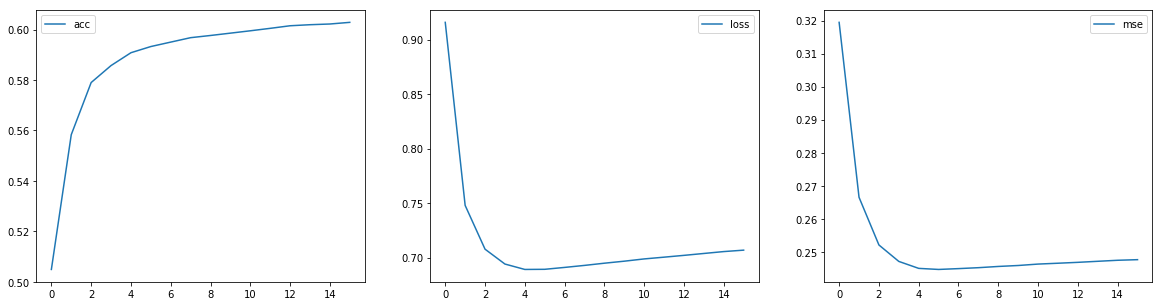

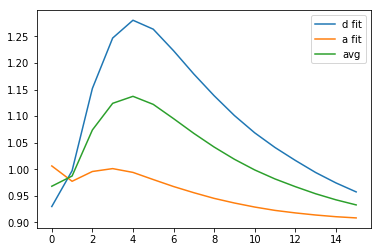

In [41]:
clear_output()
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [ ]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

In [ ]:
x = []

for _ in range(1):
    xa, _, _, _ = generate_attempts(qs,ss)
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

In [ ]:
sws = s_table.get_weights()[0]

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(sws[psi_id], pred_wgtz[q_id])
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()